In [1]:
import altair as alt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import wordcloud as wc
import sqlite3
import datetime
# import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
# %config InlineBackend.figure_formats = ['svg']

# Load data

In [2]:
ldf = pd.read_csv('crime_data.csv', index_col='Report Number', parse_dates=['Occurred Date', 'Reported Date'])
ldf.head()

,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,,,
20080000465209,2008-12-13,2114.0,2008-12-13,2114.0,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000202011,2064-06-15,0.0,2010-06-15,1031.0,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,WEST,Q,Q2,QUEEN ANNE
2012000023437,1973-01-01,0.0,2012-01-25,1048.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,N,N2,NORTHGATE
20130000327785,1974-06-01,0.0,2013-09-09,1117.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
20160000289384,1975-01-01,0.0,2016-08-11,1054.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN


# Clean dataset

In [3]:
rdf = ldf.copy()
rdf = rdf.drop(['Occurred Time', 'Reported Time'], axis=1)
rdf = rdf.rename(columns = {
  'Occurred Date': 'Occurred',
  'Reported Date': 'Reported',
  'Crime Subcategory': 'Subcategory',
  'Primary Offense Description': 'Description',
})
rdf = rdf[(~rdf['Occurred'].isna()) & (~rdf['Subcategory'].isna())]
rdf = rdf[(rdf['Occurred'] >= '2008') & (rdf['Occurred'] < datetime.datetime.now())]
rdf.head()

,Occurred,Reported,Subcategory,Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,
20080000465209,2008-12-13,2008-12-13,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
200800001981,2008-01-01,2008-01-02,CAR PROWL,THEFT-CARPROWL,SOUTHWEST,F,F3,SOUTH PARK
200800001265,2008-01-01,2008-01-01,NARCOTIC,NARC-SELL-METH,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
200800001903,2008-01-01,2008-01-02,CAR PROWL,THEFT-AUTOACC,SOUTHWEST,F,F3,SOUTH PARK
200800001226,2008-01-01,2008-01-01,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B2,FREMONT


In [4]:
df = rdf.copy()

# Take a look at each column

In [5]:
df.head()

,Occurred,Reported,Subcategory,Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,
20080000465209,2008-12-13,2008-12-13,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
200800001981,2008-01-01,2008-01-02,CAR PROWL,THEFT-CARPROWL,SOUTHWEST,F,F3,SOUTH PARK
200800001265,2008-01-01,2008-01-01,NARCOTIC,NARC-SELL-METH,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
200800001903,2008-01-01,2008-01-02,CAR PROWL,THEFT-AUTOACC,SOUTHWEST,F,F3,SOUTH PARK
200800001226,2008-01-01,2008-01-01,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B2,FREMONT


In [6]:
df[['Subcategory', 'Description', 'Sector', 'Precinct', 'Neighborhood']].nunique()

Subcategory      30
Description     142
Sector           23
Precinct          6
Neighborhood     59
dtype: int64

In [7]:
descriptions = list(df['Description'].unique())
descriptions

['DUI-LIQUOR',
 'THEFT-CARPROWL',
 'NARC-SELL-METH',
 'THEFT-AUTOACC',
 'ROBBERY-STREET-BODYFORCE',
 'BURGLARY-FORCE-RES',
 'BURGLARY-NOFORCE-NONRES',
 'VEH-THEFT-AUTO',
 'NARC-EQUIPMENT/PARAPHENALIA',
 'BURGLARY-NOFORCE-RES',
 'NARC-POSSESS-METH',
 'NARC-POSSESS-COCAINE',
 'VEH-THEFT-MTRCYCLE',
 'ROBBERY-STREET-WEAPON',
 'THEFT-SHOPLIFT',
 'SEXOFF-INDECENT LIBERTIES',
 'THEFT-BUILDING',
 'THEFT-OTH',
 'RAPE-WEAPON',
 'BURGLARY-FORCE-NONRES',
 'ASSLT-AGG-GUN',
 'TRESPASS',
 'VEH-THEFT-TRAILER',
 'LIQUOR LAW VIOLATION',
 'NARC-POSSESS-PRESCRIPTION',
 'NARC-SELL-COCAINE',
 'NARC-POSSESS-OTHER',
 'NARC-POSSESS-MARIJU',
 'ASSLT-AGG-WEAPON',
 'SEXOFF-OTHER',
 'SEXOFF-SODOMY',
 'CHILD-ABUSED-NOFORCE',
 'NARC-FORGERY-PRESCRIPTION',
 'CHILD-OTHER',
 'RAPE-STRONGARM',
 'ASSLT-AGG-BODYFORCE',
 'ROBBERY-RESIDENCE-BODYFORCE',
 'ASSLT-AGG-DV-BODYFORCE',
 'RAPE-OTHER',
 'THEFT-PKPOCKET',
 'ASSLT-AGG-DV-GUN',
 'WEAPON-POSSESSION',
 'THEFT-LICENSE PLATE',
 'SEXOFF-INDECENT EXPOSURE',
 'NARC-SELL-OTHER

In [8]:
subcategories = list(df['Subcategory'].unique())
subcategories

['DUI',
 'CAR PROWL',
 'NARCOTIC',
 'ROBBERY-STREET',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-COMMERCIAL',
 'MOTOR VEHICLE THEFT',
 'THEFT-SHOPLIFT',
 'SEX OFFENSE-OTHER',
 'THEFT-BUILDING',
 'THEFT-ALL OTHER',
 'RAPE',
 'AGGRAVATED ASSAULT',
 'TRESPASS',
 'LIQUOR LAW VIOLATION',
 'FAMILY OFFENSE-NONVIOLENT',
 'ROBBERY-RESIDENTIAL',
 'AGGRAVATED ASSAULT-DV',
 'WEAPON',
 'PROSTITUTION',
 'THEFT-BICYCLE',
 'HOMICIDE',
 'LOITERING',
 'ARSON',
 'ROBBERY-COMMERCIAL',
 'DISORDERLY CONDUCT',
 'PORNOGRAPHY',
 'GAMBLE',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'BURGLARY-COMMERCIAL-SECURE PARKING']

In [9]:
del subcategories[23]

In [10]:
subcategories

['DUI',
 'CAR PROWL',
 'NARCOTIC',
 'ROBBERY-STREET',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-COMMERCIAL',
 'MOTOR VEHICLE THEFT',
 'THEFT-SHOPLIFT',
 'SEX OFFENSE-OTHER',
 'THEFT-BUILDING',
 'THEFT-ALL OTHER',
 'RAPE',
 'AGGRAVATED ASSAULT',
 'TRESPASS',
 'LIQUOR LAW VIOLATION',
 'FAMILY OFFENSE-NONVIOLENT',
 'ROBBERY-RESIDENTIAL',
 'AGGRAVATED ASSAULT-DV',
 'WEAPON',
 'PROSTITUTION',
 'THEFT-BICYCLE',
 'HOMICIDE',
 'LOITERING',
 'ROBBERY-COMMERCIAL',
 'DISORDERLY CONDUCT',
 'PORNOGRAPHY',
 'GAMBLE',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'BURGLARY-COMMERCIAL-SECURE PARKING']

In [11]:
sorted(subcategories, key = str.lower)

['AGGRAVATED ASSAULT',
 'AGGRAVATED ASSAULT-DV',
 'BURGLARY-COMMERCIAL',
 'BURGLARY-COMMERCIAL-SECURE PARKING',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'CAR PROWL',
 'DISORDERLY CONDUCT',
 'DUI',
 'FAMILY OFFENSE-NONVIOLENT',
 'GAMBLE',
 'HOMICIDE',
 'LIQUOR LAW VIOLATION',
 'LOITERING',
 'MOTOR VEHICLE THEFT',
 'NARCOTIC',
 'PORNOGRAPHY',
 'PROSTITUTION',
 'RAPE',
 'ROBBERY-COMMERCIAL',
 'ROBBERY-RESIDENTIAL',
 'ROBBERY-STREET',
 'SEX OFFENSE-OTHER',
 'THEFT-ALL OTHER',
 'THEFT-BICYCLE',
 'THEFT-BUILDING',
 'THEFT-SHOPLIFT',
 'TRESPASS',
 'WEAPON']

Note: To reduce the number of categories, I decided to group some of them together below

In [12]:
subcategory_map = {
  'AGGRAVATED ASSAULT': 'ASSAULT',
  'AGGRAVATED ASSAULT-DV': 'ASSAULT',
  'BURGLARY-COMMERCIAL': 'BURGLARY',
  'BURGLARY-COMMERCIAL-SECURE PARKING': 'BURGLARY',
  'BURGLARY-RESIDENTIAL': 'BURGLARY',
  'BURGLARY-RESIDENTIAL-SECURE PARKING': 'BURGLARY',
  'DISORDERLY CONDUCT': 'DISORDERLY CONDUCT',
  'LOITERING': 'DISORDERLY CONDUCT',
  'TRESPASS': 'DISORDERLY CONDUCT',
  'DUI': 'SUBSTANCE',
  'LIQUOR LAW VIOLATION': 'SUBSTANCE',
  'NARCOTIC': 'SUBSTANCE',
  'PORNOGRAPHY': 'SEX OFFENSE',
  'PROSTITUTION': 'SEX OFFENSE',
  'SEX OFFENSE-OTHER': 'SEX OFFENSE',
  'ROBBERY-COMMERCIAL': 'ROBBERY',
  'ROBBERY-RESIDENTIAL': 'ROBBERY',
  'ROBBERY-STREET': 'ROBBERY',
  'THEFT-ALL OTHER': 'THEFT',
  'THEFT-BICYCLE': 'THEFT',
  'THEFT-BUILDING': 'THEFT',
  'THEFT-SHOPLIFT': 'THEFT',
  'CAR PROWL': 'THEFT',
}

In [13]:
df['Category'] = df['Subcategory'].apply(lambda subcategory: subcategory_map.get(subcategory, subcategory))

In [14]:
df = df.groupby([pd.Grouper(key='Occurred', freq='MS'), 'Neighborhood', 'Category']).size().to_frame('Incidents').reset_index()

In [15]:
df.shape

(57700, 4)

In [16]:
df.head()

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1


In [17]:
ntdf = df.groupby('Neighborhood').size().to_frame('Incidents').reset_index()
ntdf.head()

,Neighborhood,Incidents
0,ALASKA JUNCTION,993
1,ALKI,686
2,BALLARD NORTH,1128
3,BALLARD SOUTH,1164
4,BELLTOWN,1221


In [18]:
ntdf.shape

(59, 2)

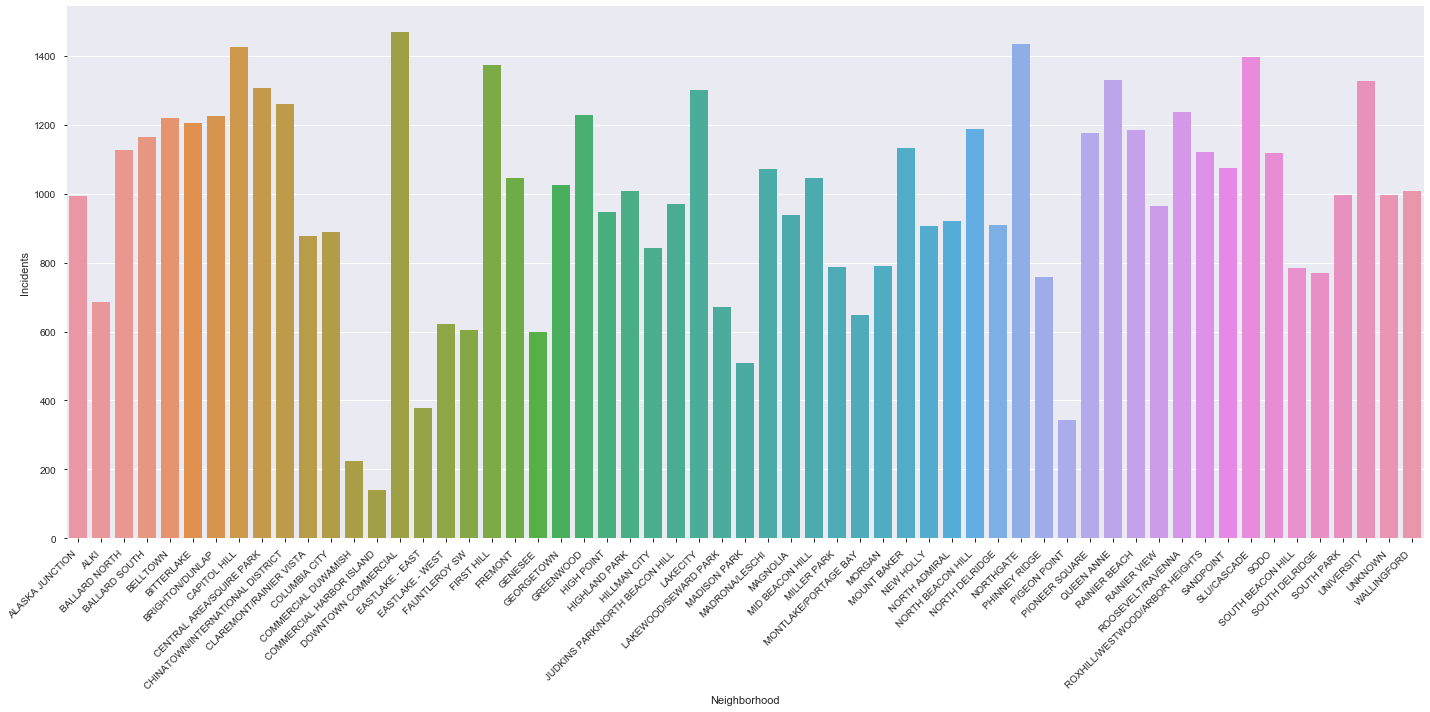

In [19]:
fig = plt.figure(figsize=(20, 10))

#plt.bar(range(len(ntdf.Neighborhood)), ntdf.Incidents)

#create your ax object here
#ax = plt.subplot()
#ax.set_xticks(range(len(ntdf.Neighborhood)))
#ax.set_xticklabels(ntdf.Neighborhood)

chart = sns.barplot(data= ntdf, x= 'Neighborhood', y= 'Incidents')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()

# How has the number of incidents fluctuated over the years by type of crime (and by Neighborhood)?

In [20]:
categories = list(df.Category.unique())
categories

['ASSAULT',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'MOTOR VEHICLE THEFT',
 'ROBBERY',
 'SEX OFFENSE',
 'SUBSTANCE',
 'THEFT',
 'RAPE',
 'WEAPON',
 'HOMICIDE',
 'FAMILY OFFENSE-NONVIOLENT',
 'ARSON',
 'GAMBLE']

In [21]:
neighborhoods = list(df.Neighborhood.unique())
neighborhoods

['ALASKA JUNCTION',
 'ALKI',
 'BALLARD NORTH',
 'BALLARD SOUTH',
 'BELLTOWN',
 'BITTERLAKE',
 'BRIGHTON/DUNLAP',
 'CAPITOL HILL',
 'CENTRAL AREA/SQUIRE PARK',
 'CHINATOWN/INTERNATIONAL DISTRICT',
 'CLAREMONT/RAINIER VISTA',
 'COLUMBIA CITY',
 'COMMERCIAL DUWAMISH',
 'COMMERCIAL HARBOR ISLAND',
 'DOWNTOWN COMMERCIAL',
 'EASTLAKE - EAST',
 'EASTLAKE - WEST',
 'FAUNTLEROY SW',
 'FIRST HILL',
 'FREMONT',
 'GENESEE',
 'GEORGETOWN',
 'GREENWOOD',
 'HIGH POINT',
 'HIGHLAND PARK',
 'HILLMAN CITY',
 'JUDKINS PARK/NORTH BEACON HILL',
 'LAKECITY',
 'LAKEWOOD/SEWARD PARK',
 'MADISON PARK',
 'MADRONA/LESCHI',
 'MAGNOLIA',
 'MID BEACON HILL',
 'MILLER PARK',
 'MONTLAKE/PORTAGE BAY',
 'MORGAN',
 'MOUNT BAKER',
 'NEW HOLLY',
 'NORTH ADMIRAL',
 'NORTH BEACON HILL',
 'NORTH DELRIDGE',
 'NORTHGATE',
 'PHINNEY RIDGE',
 'PIGEON POINT',
 'PIONEER SQUARE',
 'QUEEN ANNE',
 'RAINIER BEACH',
 'RAINIER VIEW',
 'ROOSEVELT/RAVENNA',
 'ROXHILL/WESTWOOD/ARBOR HEIGHTS',
 'SANDPOINT',
 'SLU/CASCADE',
 'SODO',
 'SOUTH 

Note: To match Abbie's presentation on Fifi data, I grouped some neighborhoods together. 

In [22]:
neighborhood_map = {
  'FREMONT': 'Fmt/Wfd/GW',
  'WALLINGFORD': 'Fmt/Wfd/GW',
  'GREENWOOD': 'Fmt/Wfd/GW',
  'MID BEACON HILL': 'BH/GT',
  'GEORGETOWN': 'BH/GT',
  'BALLARD NORTH': 'Ballard',
  'BALLARD SOUTH': 'Ballard',
  'CAPITOL HILL': 'CapitolH/Eastlk',
  'EASTLAKE - EAST': 'CapitolH/Eastlk',
  'EASTLAKE - WEST': 'CapitolH/Eastlk',
  'BELLTOWN': 'Blltwn/Dwntwn/PionrSq',
  'DOWNTOWN COMMERCIAL': 'Blltwn/Dwntwn/PionrSq',
  'PIONEER SQUARE': 'Blltwn/Dwntwn/PionrSq',
}

In [23]:
odf = df.copy()

In [24]:
odf['Neighborhood'] = odf['Neighborhood'].apply(lambda neighborhood: neighborhood_map.get(neighborhood, neighborhood))

In [25]:
odf = odf[odf.Category != 'GAMBLE']
odf.head()

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1


Note: There are too many neighborhoods, so I picked the ones that Abbie highlighted in her talk, and included the downtown area just out of my own curiosity.

In [26]:
neighborhoods = ['Fmt/Wfd/GW', 'QUEEN ANNE', 'BH/GT', 'Ballard', 'MAGNOLIA', 'CapitolH/Eastlk', 'Blltwn/Dwntwn/PionrSq']
odf = odf[odf.Neighborhood.isin(neighborhoods)]

In [27]:
odf.head(10)

,Occurred,Neighborhood,Category,Incidents
12,2008-01-01,Ballard,BURGLARY,17
13,2008-01-01,Ballard,DISORDERLY CONDUCT,1
14,2008-01-01,Ballard,MOTOR VEHICLE THEFT,9
15,2008-01-01,Ballard,ROBBERY,5
16,2008-01-01,Ballard,SEX OFFENSE,1
17,2008-01-01,Ballard,SUBSTANCE,1
18,2008-01-01,Ballard,THEFT,38
19,2008-01-01,Ballard,BURGLARY,11
20,2008-01-01,Ballard,DISORDERLY CONDUCT,4
21,2008-01-01,Ballard,MOTOR VEHICLE THEFT,18


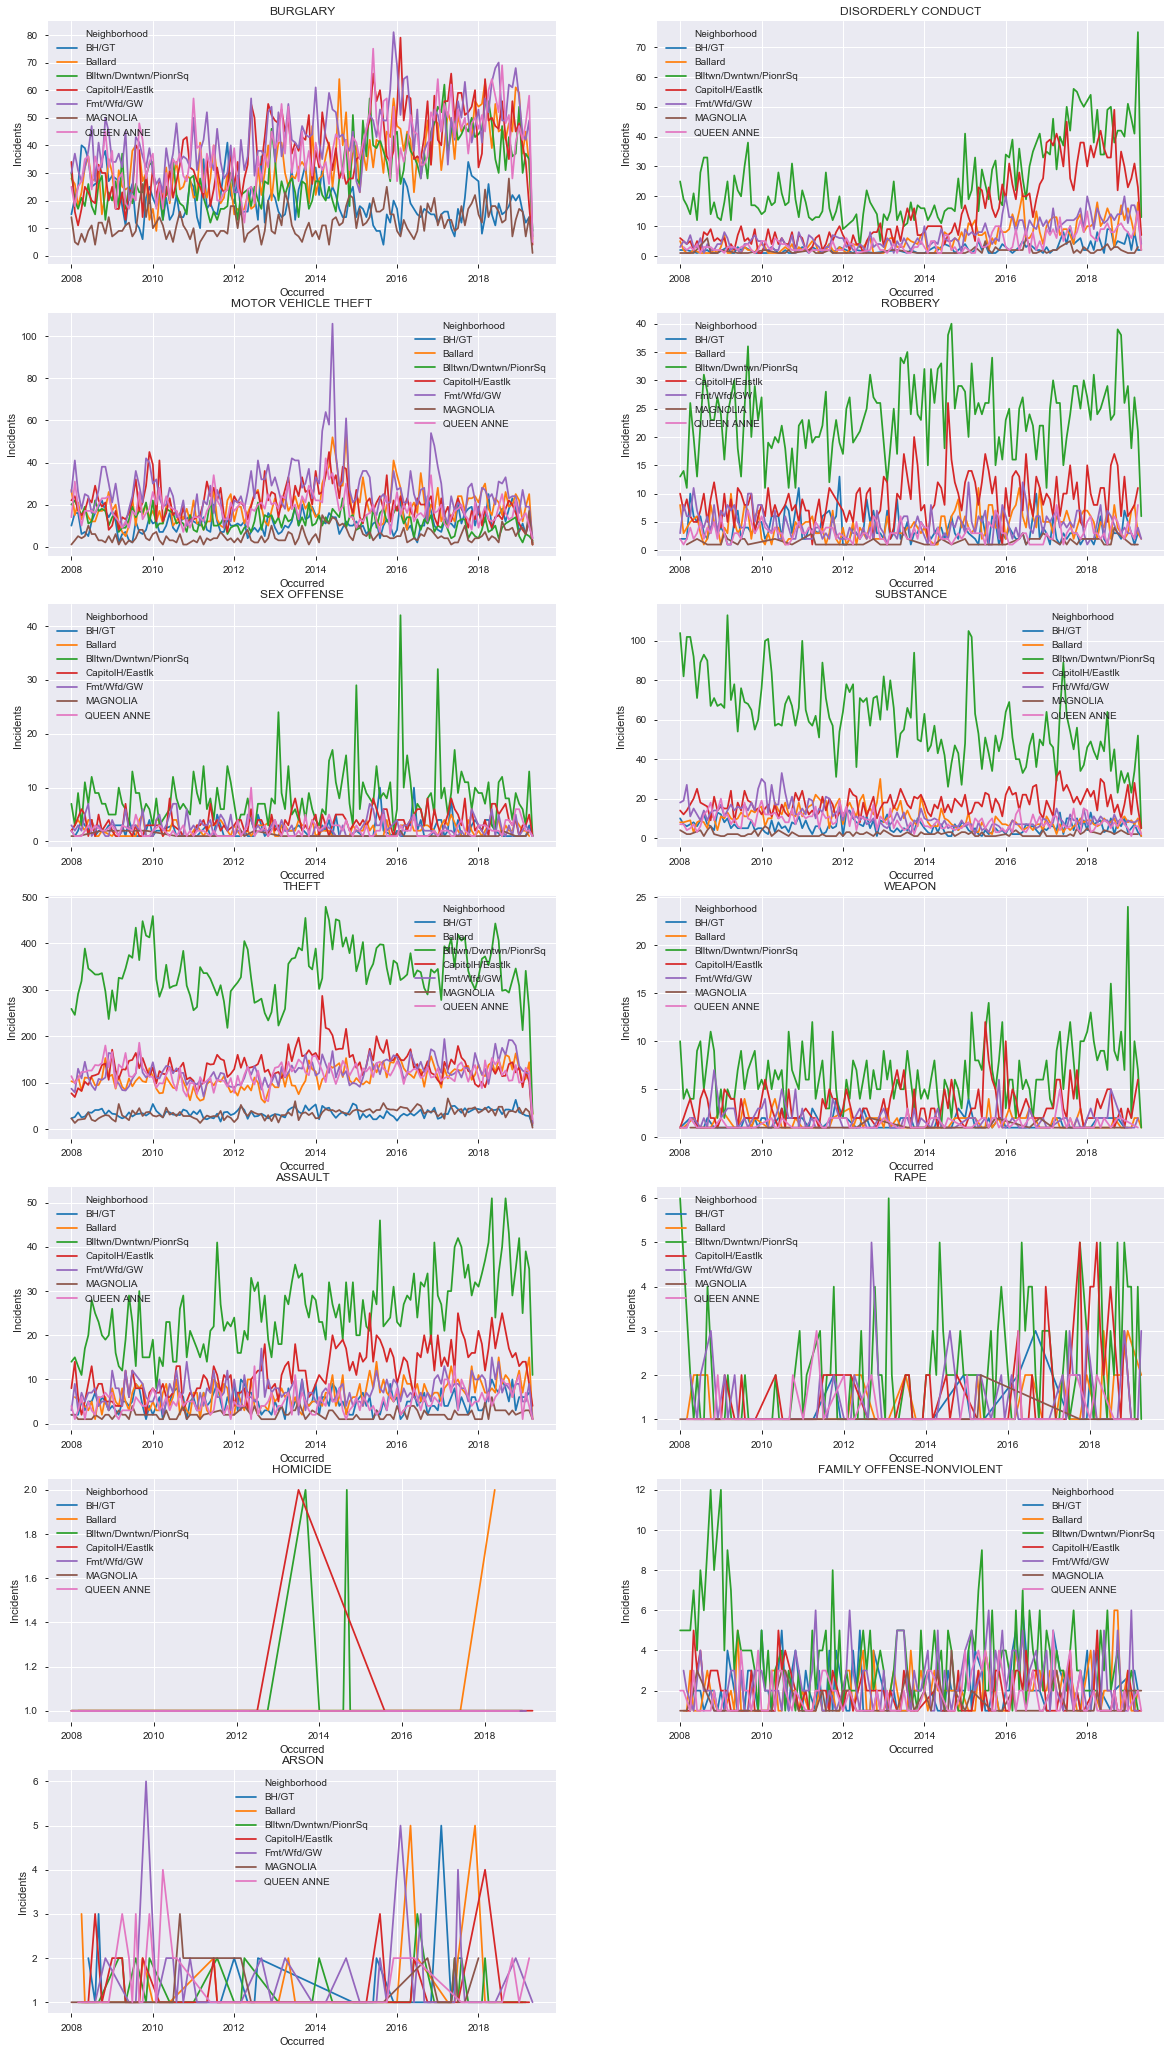

In [35]:
fig = plt.figure(figsize=(20, 160))
for i, crime_type in enumerate(odf.Category.unique()):
  crime_type_data = odf[odf.Category == crime_type]
  crime_type_data = crime_type_data.groupby(['Neighborhood', 'Occurred'])['Incidents'].sum().reset_index()

  fig.add_subplot(30, 2, i + 1)
  sns.lineplot(x="Occurred", y="Incidents", hue="Neighborhood", data=crime_type_data)

  ax = plt.gca()
  ax.set_title(crime_type)

Note: Not surprisingly, the downtown/Belltown/Pinoneer Square area has had more incidents than other neighborhoods in general.

# Combining all years, are there crime types that are more common within each neighborhood?

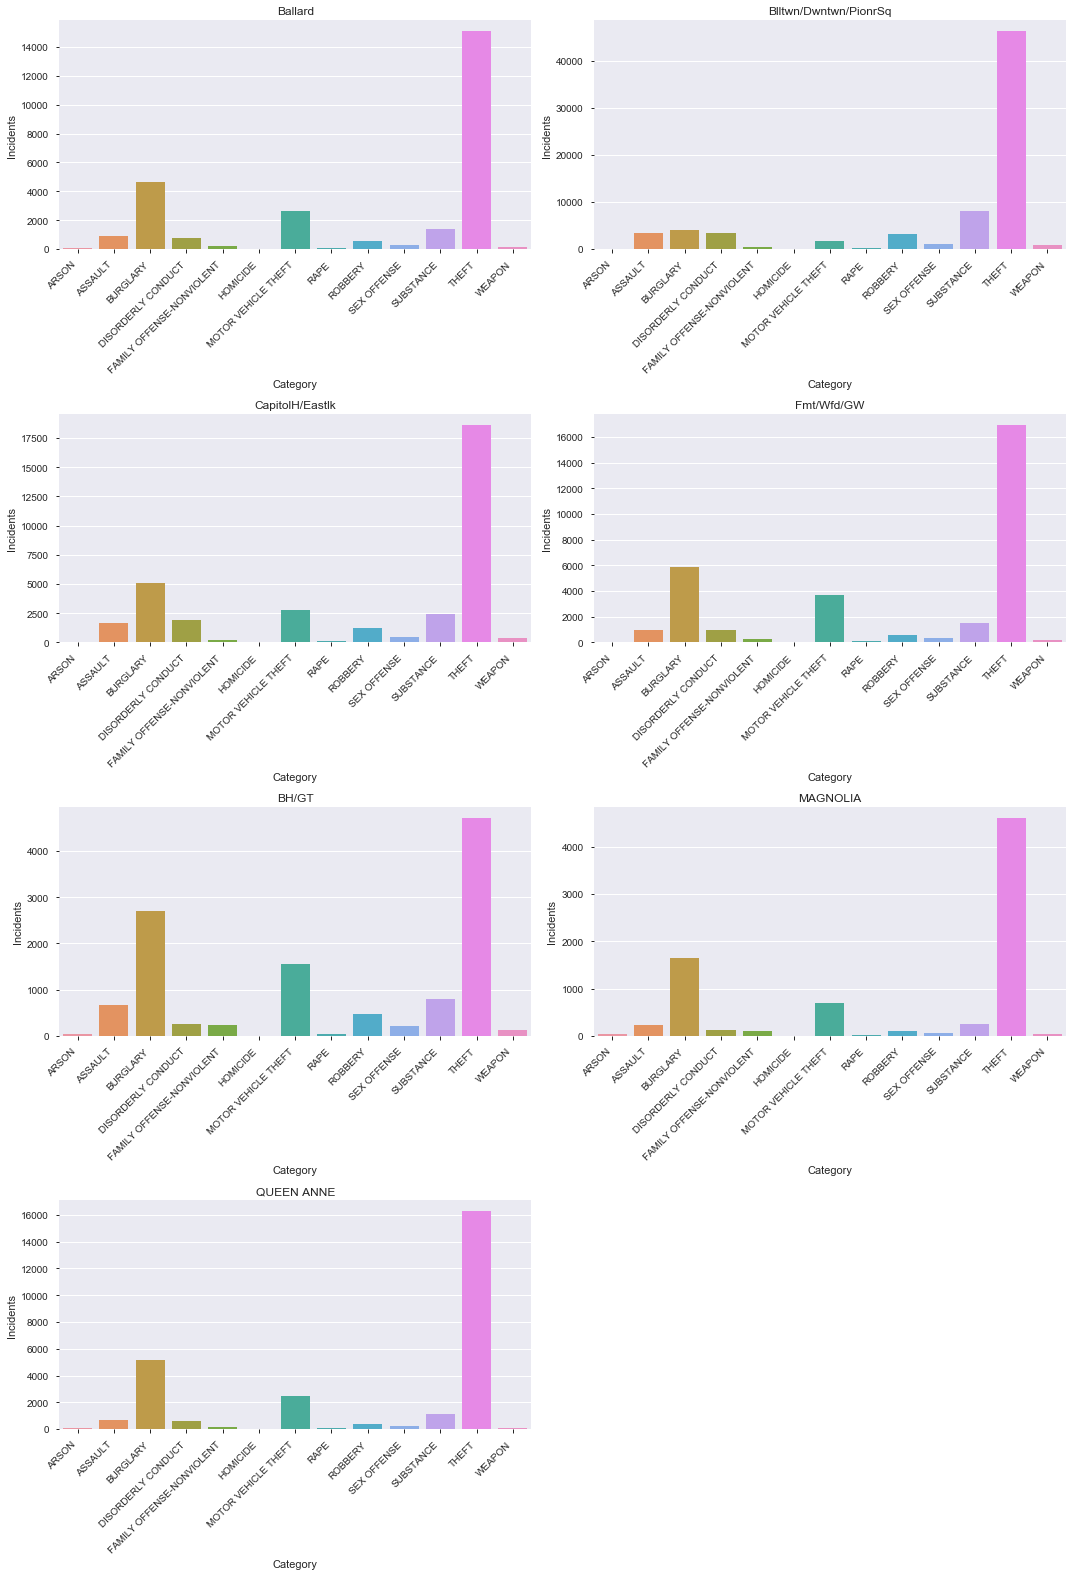

In [36]:
fig = plt.figure(figsize=(15, 22))
for i, neighborhood in enumerate(odf.Neighborhood.unique()):
  neighborhood_data = odf[odf.Neighborhood == neighborhood]
  neighborhood_data = neighborhood_data.groupby(['Neighborhood', 'Category'])['Incidents'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  chart = sns.barplot(data= neighborhood_data, x= 'Category', y= 'Incidents')
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

  ax = plt.gca()
  ax.set_title(neighborhood)
plt.tight_layout()

Note: In all neighborhoods, theft is the most common type of crime.

# Combining all years, were there more incidents in some neighborhoods than others (by crime type)? 

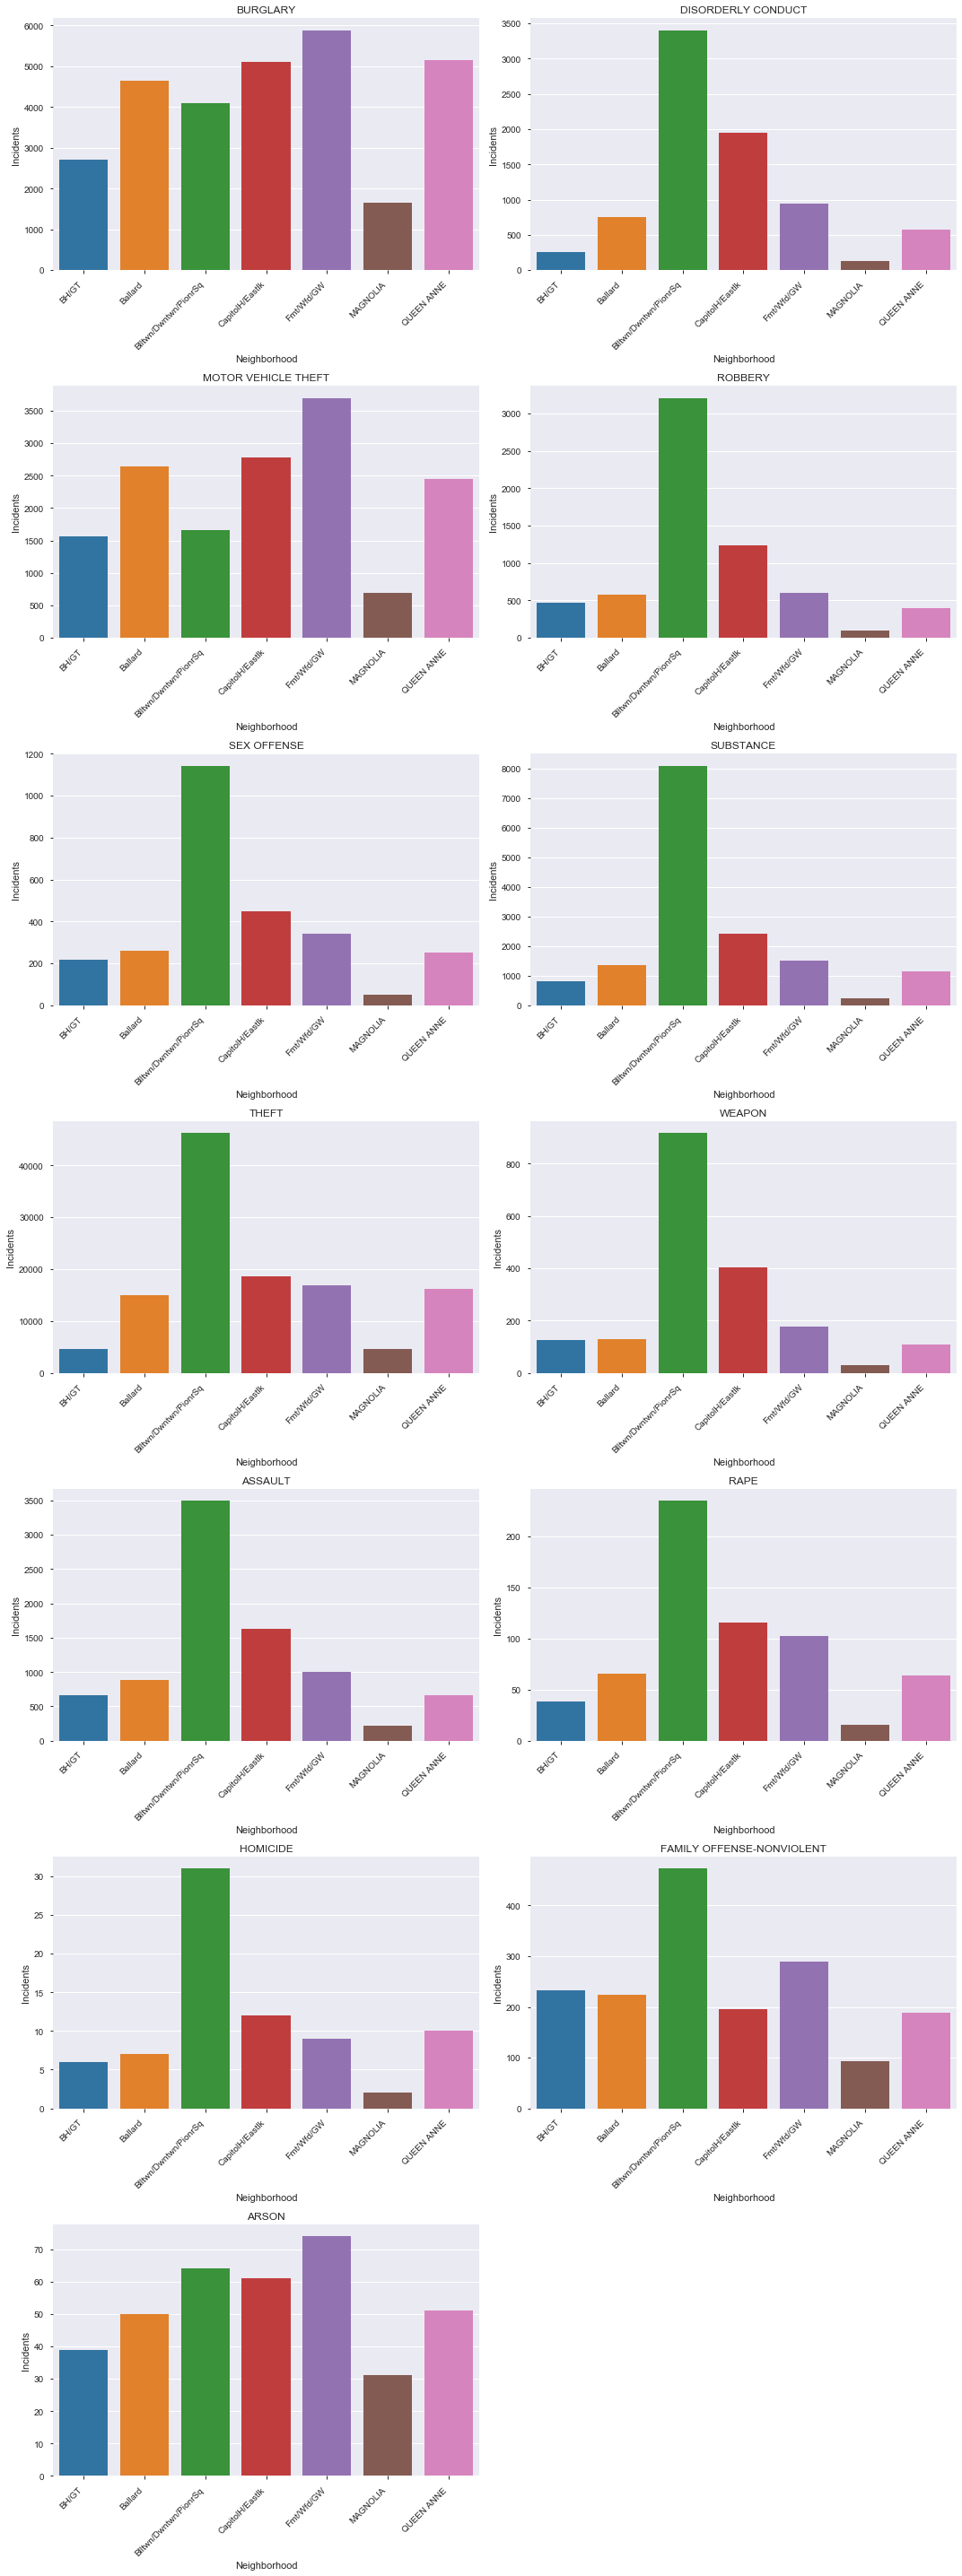

In [38]:
fig = plt.figure(figsize=(15, 40))
for i, crime_type in enumerate(odf.Category.unique()):
  crime_type_data = odf[odf.Category == crime_type]
  crime_type_data = crime_type_data.groupby(['Neighborhood', 'Category'])['Incidents'].sum().reset_index()

  fig.add_subplot(7, 2, i + 1)
  chart = sns.barplot(data=crime_type_data, x='Neighborhood', y='Incidents')
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
  
  ax = plt.gca()
  ax.set_title(crime_type)

plt.tight_layout()

Note: Again, the downtown area has had more incidents than other neighborhoods, followed by the Fremont/Wallingoford/Greenwood area and Capitol Hill/East Lake area.

In [39]:
ff = pd.read_pickle('../../../WIDS_FIFI_groupproject/generated_datasets/data_final.pkl')

In [40]:
ff.head()

,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,zip,neighborhood,SittingInformal,Lying,DisruptiveActivity_Aggressive,DisruptiveActivity_Intoxicated,LivingActivities,Soliciting,overdose,pop,pop_dens,housing_units,med_home,land_area,occupied_units,occupied_ratio,med_income,med_age,male_%,white_%,fam_%,nokid_%,mortgage_%,fulltime_%,unemploy,drive_%,publictrans_%,other_%,wrk_travel,city council,county council
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13-00064098,2013-08-13 18:05:17,"2629 SW ANDOVER ST, SEATTLE, WA","26012799 SW Andover St, Seattle; XY: 1261975.9...",NaN,Acxo217,NaN,Suzuki,Other,Over 1 Week,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-13,2013,8,13,Tuesday,18,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13-00064109,2013-08-13 18:57:44,"402 BELMONT AVE E, SEATTLE, WA","327 Belmont Ave E, Seattle; XY: 1272796.132329...",I don't think this car has been moved in quite...,379 vuq,NaN,Volkswagen,Silver,Over 3 Days,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-13,2013,8,13,Tuesday,18,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13-00064128,2013-08-13 20:24:22,"5283 39TH AVE S, SEATTLE, WA","5239 39th Ave S Seattle, WA 98118; XY: 1282330...",Older Honda with flat tire,See photo,NaN,Honda,Blue,Over 1 Month,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-13,2013,8,13,Tuesday,20,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13-00064164,2013-08-14 06:51:34,"4755 38TH AVE SW, SEATTLE, WA","XY: 1258575.3814046786, 207971.16513023284; La...",Green 4 door Volkswagen Golf,WA AGD9667,NaN,Volkswagen,Green,Over 1 Month,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-14,2013,8,14,Wednesday,6,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
abbie_neighborhoods = list(ff['neighborhood'].unique())
sorted(abbie_neighborhoods, key = str.lower)
#sorted(subcategories, key = str.lower)

['Ballard/SunsetH',
 'BeaconH/MtBaker/Leschi',
 'Belltown',
 'BH/GT/SP',
 'Broadview/SpringBh',
 'Burien/NorPk',
 'CapitolH/Eastlk',
 'CD/CH/Madrona',
 'CH/MadisonPkVy',
 'ColCity/SewardP/RainierV',
 'Dt/FirstH',
 'DT?',
 'Fmt/Wfd/GL/GW',
 'HarborIs/IndustD',
 'HighPt/Delridge',
 'Kenmore',
 'Kent',
 'Kitsap',
 'Lakerdg/Skywy/Allentn/BrynMr',
 'Latona/Highline',
 'LFP/RidgeC',
 'Magnolia',
 'NAdmiral/Alki',
 'NBd/LH/CH/WH/NB',
 'Northgate/LkCity',
 'PioneerS/FirstH/ID',
 'QA/InterBay',
 'Ravenna/ML/GL',
 'Renton',
 'Riverview/Delridge',
 'SeaTac/Tukwila',
 'Seaview/Fauntleroy',
 'Shoreline/Bitterlake',
 'SLU/QA/WL',
 'Sunnydale/NormandyPk',
 'Udist/LarHur',
 'UW_main',
 'WA',
 'WhiteCr/Shorewd']

In [42]:
ff_neighborhood = ['Ballard/SunsetH',
'BeaconH/MtBaker/Leschi',
'BH/GT/SP',
'Belltown',
'CapitolH/Eastlk',
'CD/CH/Madrona',
'CH/MadisonPkVy',
'ColCity/SewardP/RainierV',
'Dt/FirstH',
'Fmt/Wfd/GL/GW',
'HarborIs/IndustD',
'HighPt/Delridge',
'Magnolia',
'NAdmiral/Alki',
'NBd/LH/CH/WH/NB',
'Northgate/LkCity',
'PioneerS/FirstH/ID',
'QA/InterBay',
'Ravenna/ML/GL',
'Riverview/Delridge',
'Shoreline/Bitterlake',
'SLU/QA/WL',
'Udist/LarHur',
'UW_main']
ff = ff[ff.neighborhood.isin(ff_neighborhood)]

In [43]:
ff = ff.rename(columns = {
  'Service_Request_Number': 'RequestNum',
})

In [44]:
ff = ff[['Created_Date', 'date', 'year', 'month', 'day', 'neighborhood', 'FIFI_category', 'RequestNum']]
ff.head()

,Created_Date,date,year,month,day,neighborhood,FIFI_category,RequestNum
37881,2013-08-16 18:41:32.999,2013-08-16,2013,8,16,Ravenna/ML/GL,Abnd_Vehicle,13-00065576
37882,2013-08-18 23:27:54.999,2013-08-18,2013,8,18,Ravenna/ML/GL,Abnd_Vehicle,13-00065844
37883,2013-08-19 23:54:02.000,2013-08-19,2013,8,19,Ravenna/ML/GL,Abnd_Vehicle,13-00066386
37884,2015-10-19 08:35:16.999,2015-10-19,2015,10,19,Ravenna/ML/GL,Abnd_Vehicle,15-00150784
37885,2015-10-19 14:33:01.999,2015-10-19,2015,10,19,Ravenna/ML/GL,Abnd_Vehicle,15-00151301


In [45]:
ff = ff[ff.neighborhood != 'WA']
ff.shape

(206355, 8)

In [47]:
ffdf = ff.groupby([pd.Grouper(key='Created_Date', freq='MS'), 'neighborhood', 'FIFI_category']).size().to_frame('Incidents').reset_index()
ffdf.head()

,Created_Date,neighborhood,FIFI_category,Incidents
0,2013-08-01,Fmt/Wfd/GL/GW,Abnd_Vehicle,1
1,2013-08-01,Northgate/LkCity,Abnd_Vehicle,2
2,2013-08-01,Ravenna/ML/GL,Abnd_Vehicle,3
3,2015-06-01,BH/GT/SP,Other,1
4,2015-10-01,BH/GT/SP,Abnd_Vehicle,9


# Re-sorting neighborhoods in the crime dataset

In [58]:
c_neighborhood_map = {
  'BALLARD NORTH': 'Ballard/SunsetH',
  'BALLARD SOUTH': 'Ballard/SunsetH',
  'MID BEACON HILL': 'BeaconH/MtBaker/Leschi',
  'NORTH BEACON HILL': 'BeaconH/MtBaker/Leschi',
  'MOUNT BAKER': 'BeaconH/MtBaker/Leschi',
  'JUDKINS PARK/NORTH BEACON HILL': 'BeaconH/MtBaker/Leschi',
  'SOUTH BEACON HILL': 'BeaconH/MtBaker/Leschi',
  'GEORGETOWN': 'BH/GT/SP',
  'BELLTOWN': 'Belltown',
  'CAPITOL HILL': 'CapitolH/Eastlk',
  'EASTLAKE - EAST': 'CapitolH/Eastlk',
  'EASTLAKE - WEST': 'CapitolH/Eastlk',
  'MADRONA/LESCHI':'CD/CH/Madrona',
  'CHINATOWN/INTERNATIONAL DISTRICT': 'ID/SODO',
  'SODO': 'ID/SODO',
  'MADISON PARK': 'CH/MadisonPkVy',
  'COLUMBIA CITY': 'ColCity/SewardP/RainierV',
  'RAINIER VIEW': 'ColCity/SewardP/RainierV',
  'DOWNTOWN COMMERCIAL': 'Dt/FirstH',
  'FIRST HILL': 'Dt/FirstH',
  'FREMONT': 'Fmt/Wfd/GL/GW',
  'WALLINGFORD': 'Fmt/Wfd/GL/GW',
  'GREENWOOD': 'Fmt/Wfd/GL/GW',
  'COMMERCIAL HARBOR ISLAND': 'HarborIs/IndustD',
  'HIGH POINT': 'HighPt/Delridge',
  'MAGNOLIA': 'Magnolia',
  'ALKI': 'NAdmiral/Alki',
  'NORTHGATE': 'Northgate/LkCity',
  'LAKECITY': 'Northgate/LkCity',
  'PIONEER SQUARE': 'PioneerS/FirstH/ID',
  'QUEEN ANNE': 'QA/InterBay',
  'MONTLAKE/PORTAGE BAY': 'Ravenna/ML/GL',
  'ROOSEVELT/RAVENNA': 'Ravenna/ML/GL',
  'NORTH DELRIDGE': 'Riverview/Delridge',
  'SOUTH DELRIDGE': 'Riverview/Delridge',
  'BITTERLAKE': 'Shoreline/Bitterlake',
  'SLU/CASCADE': 'SLU/QA/WL',
  'UNIVERSITY': 'Udist/LarHur'
}

In [59]:
mdf = df.copy()

In [60]:
mdf.head()

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1


In [61]:
mdf['Neighborhood'] = mdf['Neighborhood'].apply(lambda neighborhood: c_neighborhood_map.get(neighborhood, neighborhood))

In [126]:
mdf.head()

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1


# Merging Fifi and crime datasets

In [ ]:
ff_crime = pd.merge(
  ffdf,
  mdf,
  left_on='Neighborhood',

)

In [63]:
mdf.head()

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1


In [83]:
pmdf = mdf.pivot_table(
  values=['Incidents'], 
  index=['Occurred', 'Neighborhood'], 
#   columns=['Category'], 
  aggfunc='sum')
pmdf.head()

Incidents
Occurred   Neighborhood                     
2008-01-01 ALASKA JUNCTION                36
           BH/GT/SP                       33
           BRIGHTON/DUNLAP                63
           Ballard/SunsetH               182
           BeaconH/MtBaker/Leschi        192

In [84]:
pffdf = ffdf.pivot_table(
  values=['Incidents'], 
  index=['Created_Date', 'neighborhood'], 
  aggfunc='sum')
pffdf.index.set_names(['Occurred', 'Neighborhood'], inplace=True)
pffdf.head()

Incidents
Occurred   Neighborhood               
2013-08-01 Fmt/Wfd/GL/GW             1
           Northgate/LkCity          2
           Ravenna/ML/GL             3
2015-06-01 BH/GT/SP                  1
2015-10-01 BH/GT/SP                 59

In [125]:
jdf = pd.merge(pmdf, pffdf, left_index=True, right_index=True)
jdf = jdf.rename({'Incidents_x': 'Crime_Incidents', 'Incidents_y': 'Fifi_Requests'}, axis=1)
jdf = jdf.reset_index()
jdf.head(10)

,Occurred,Neighborhood,Crime_Incidents,Fifi_Requests
0,2013-08-01,Fmt/Wfd/GL/GW,235,1
1,2013-08-01,Northgate/LkCity,364,2
2,2013-08-01,Ravenna/ML/GL,195,3
3,2015-06-01,BH/GT/SP,35,1
4,2015-10-01,BH/GT/SP,45,59
5,2015-10-01,Ballard/SunsetH,208,188
6,2015-10-01,BeaconH/MtBaker/Leschi,242,96
7,2015-10-01,Belltown,107,20
8,2015-10-01,CD/CH/Madrona,65,134
9,2015-10-01,CH/MadisonPkVy,13,40


# The total number of Fifi requests and crime reports (2013-2019) per neighborhood

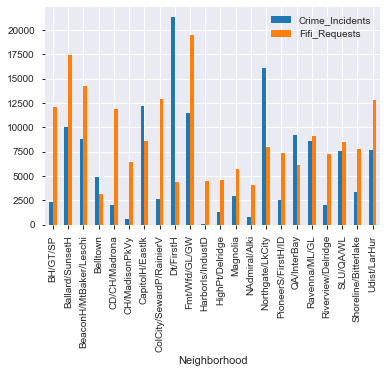

In [101]:
sdf = jdf.groupby(['Neighborhood']).sum()
sdf.plot.bar()

# The trend in Fifi requests and crime reports (all neighborhoods combined) from 2013 - 2019

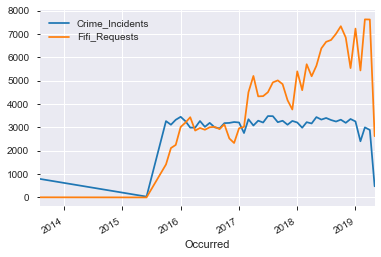

In [102]:
sdf = jdf.groupby(['Occurred']).sum()
sdf.plot()

# The trend in Fifi requests and crime reports (all neighborhoods combined) from 2013 - 2019

In [109]:
jdf.head()

,Occurred,Neighborhood,Crime_Incidents,Fifi_Requests
0,2013-08-01,Fmt/Wfd/GL/GW,235,1
1,2013-08-01,Northgate/LkCity,364,2
2,2013-08-01,Ravenna/ML/GL,195,3
3,2015-06-01,BH/GT/SP,35,1
4,2015-10-01,BH/GT/SP,45,59


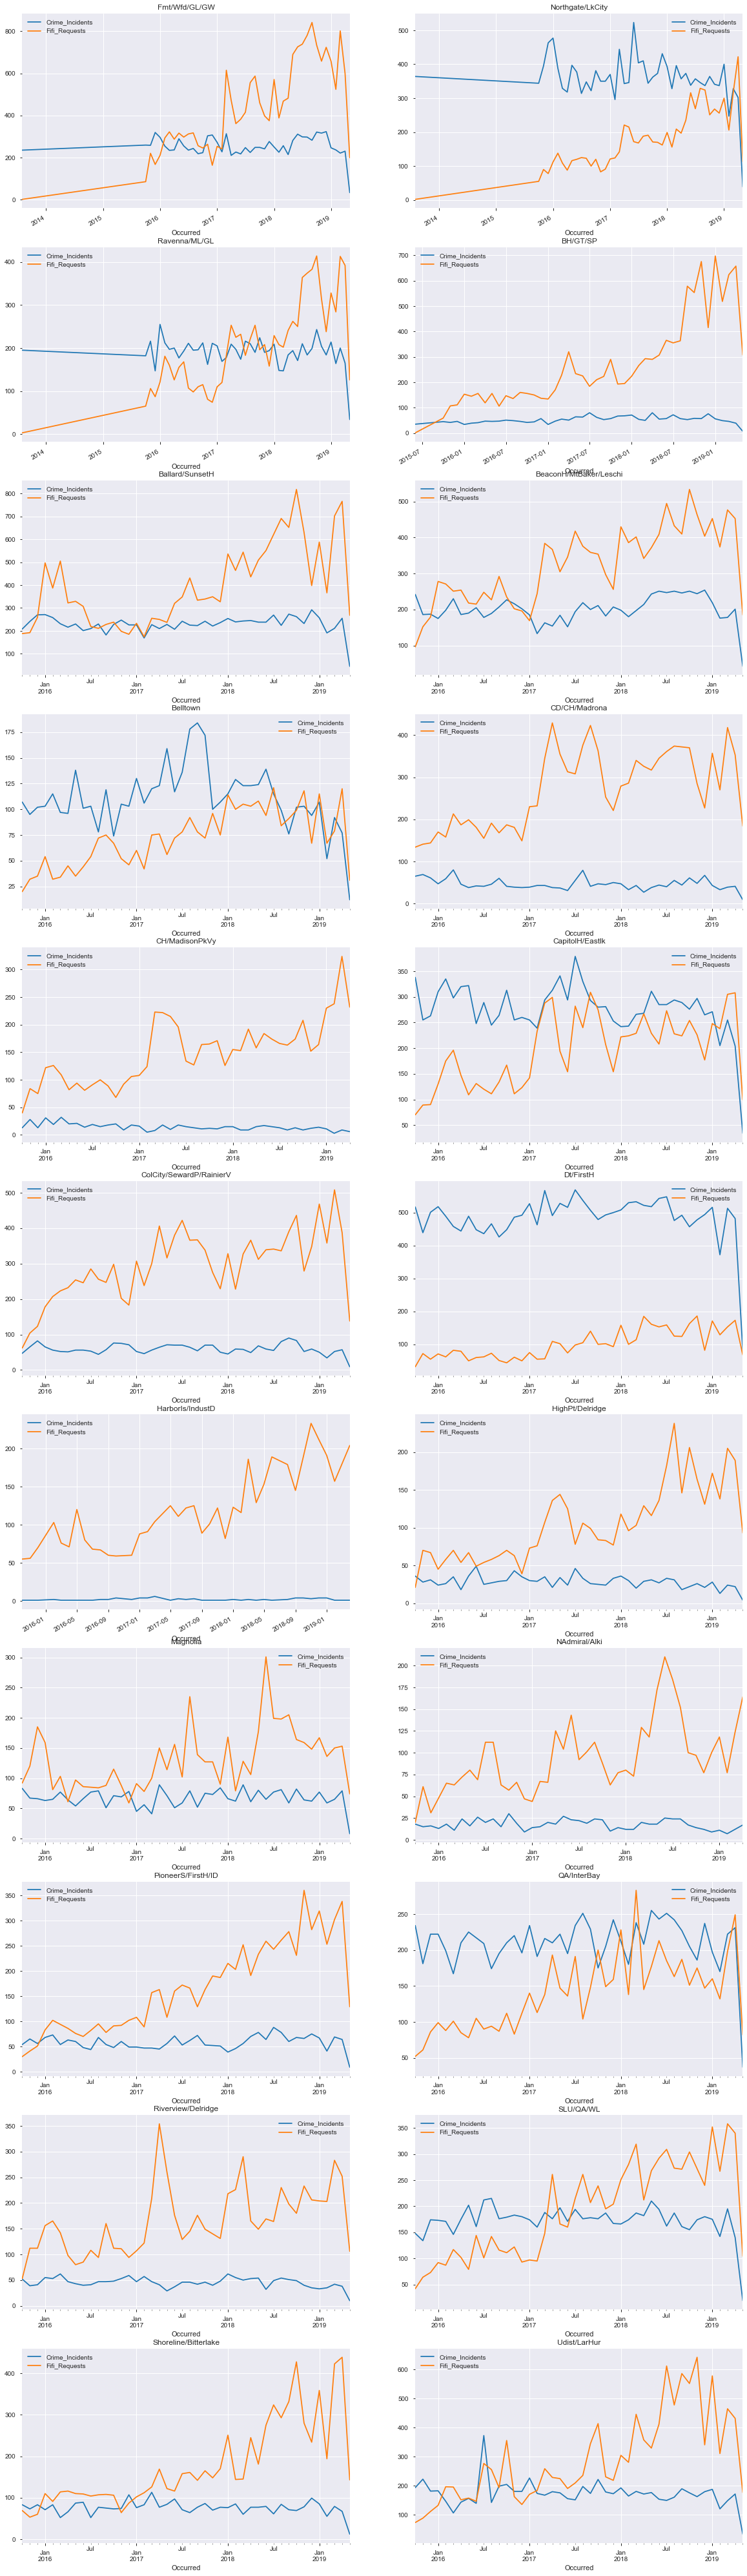

In [124]:
neighborhoods = jdf['Neighborhood'].unique()
fig, axes = plt.subplots(nrows=-(-len(neighborhoods) // 2), ncols=2, figsize=(20, 80))
for i, neighborhood in enumerate(neighborhoods):
  gdf = jdf[jdf['Neighborhood'] == neighborhood]
  gdf = gdf.groupby(['Occurred']).sum()
  gdf.plot(ax=axes[i // 2, i % 2])
  axes[i // 2, i % 2].set_title(neighborhood)